In [12]:
# Below are our imports for the spectrogram creation task
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
# Since we have multiple actors in our dataset, we would like to create a pandas dataframe to tag emotion to each audio file
ravdess_path = '../dataset/archive/'
ravdess_dir = os.listdir(ravdess_path)
file_emotion = [] # This will be a list of tuples (emotion, file)

# int to emotion mapping
lookup_table = {
    1 : 'neutral',
    2 : 'calm',
    3 : 'happy',
    4 : 'sad',
    5 : 'angry',
    6 : 'fearful',
    7 : 'disgust',
    8 : 'surprised'
}

for actor_dir in ravdess_dir:
    # ignore . files, happens on mac
    if actor_dir[0] == '.':
        continue
    for file in os.listdir(ravdess_path + actor_dir):
        emotion = lookup_table[int(file.split('-')[2])] # Get the emotion from the file name
        file_emotion.append((emotion, file))
    

emotion_tag_df = pd.DataFrame(file_emotion, columns=['emotion', 'file_path'], index=None)

# emotion_tag_df.head()
emotion_tag_df.count()

# export to csv
# emotion_tag_df.to_csv('../dataset/emotion_tag.csv', index=False)


emotion      1440
file_path    1440
dtype: int64

## Visualizing Data

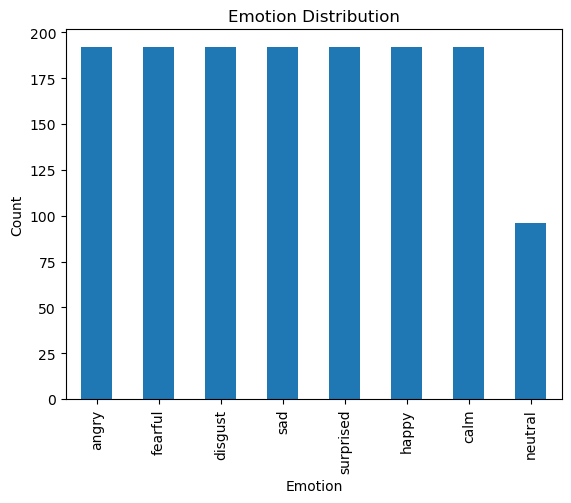

In [33]:
# let us plot the emotion distribution
plt.title('Emotion Distribution')
plt.xlabel('Emotion', )
plt.ylabel('Count')
# plot x axis as emotion and y axis as count
emotion_tag_df['emotion'].value_counts().plot(kind='bar')

plt.show()